In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
using ArraysOfArrays
using SummationByPartsOperators
using LinearAlgebra

nthreads = 2


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [102]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [84]:
## initial data configurations

trys = false
thermal = false
weibel = false
weibel_norel = false
#trys = true
#thermal = true
weibel = true
#weibel_norel = true




true

In [95]:
const order = 5
const D = 2


# Particle numbers
const N_exp = 5 #6
N = 10^(N_exp)

if  thermal
    run_name = "thermal_norel_"
    data_name = "par_dis_norel_thermal_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    nm = [1,1]
    Box_array = [i for i in Box_x]
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 8
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    par_init = (α, nm)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box[2]-Box[1])x$(Box[4]-Box[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]__Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel_norel
    run_name = "weibel_norel_"
    data_name = "par_dis_norel_weibel_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 1/2 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D,Ax)
    par_init = (α, Ax)
    data_name = data_name * "Ax_(1d2)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_(1d2)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel 
    run_name = "weibel_"
    data_name = "par_dis_rel_weibel_"
    J = (50,50)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 25 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ1 = 10.0^(-exp_Theta)
    θ2 = Ax * θ1
    p_max = 10*θ2
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_init = (α, Ax)
    @show pars_f = (θ1,θ2,Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
end



@show data_name 

# Evolution parameters
exp_t = -1.0 #2
t = 0.0
t_i = 0.0
t_f = 10.0^(exp_t)
M = 11 #16001# 4001 # 81 # 2001 # time steps 
M_g = 11 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box_x,J)
@show dx_min = minimum(dx)
@show dt = (t_f-t_i)/(M-1)
@show CFL = dt/dx_min


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[1], xmax=Box_x[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[3], xmax=Box_x[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
const σx = 1.0 #dissipation strength
const σy = 1.0 #dissipation strength


@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box_x, order)
#@show pars_f = (θ1,θ2,)



println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,10*t_f))_N$(N_exp)_M$(M)_o$(order)"
println(run_name)
println(data_name)


pars_f = (θ1, θ2, Ax) = (0.001, 0.025, 25)
data_name = "par_dis_rel_weibel_Ax_25_alp8_N5_Th3"
dx_min = minimum(dx) = 0.02
dt = (t_f - t_i) / (M - 1) = 0.01
CFL = dt / dx_min = 0.5
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 0.1, 11, 11, 0.01)
par_grid = (N, J, Box_x, order) = (100000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5)
t_f = 0.1, M = 11, dt = 0.01, exp_Theta = 3
weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_1_N5_M11_o5
par_dis_rel_weibel_Ax_25_alp8_N5_Th3


In [87]:
par_dis, data_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([0.669476545752844, 0.49294697661762865, -0.030379745781896783, 0.09215494300508353, 0.5326569618479964, 0.1173438629303113, 0.01677301128856379, -0.08104527116623056, 0.32991821228229967, 0.9939819170239349  …  -0.008118772464224433, -0.08064730639131751, 0.7040143100462987, 0.14006426115964787, 0.057242494864922056, 0.024879494554312542, 0.6398946988491334, 0.6634572085065977, -0.016186210636044196, -0.09949351300732545], "par_dis_rel_weibel_Ax_25_alp8_N5_Th3", (100000,), (1.0e-8, [0.0, 0.0], (0.0, 1.0, 0.0, 1.0)), (0.0, 1.0, 0.0, 1.0), (0.001, 0.025, [0.5, 0.0], 0.007760848597927437, 2), (-0.25, 0.25, -0.25, 0.25))

### Check Density

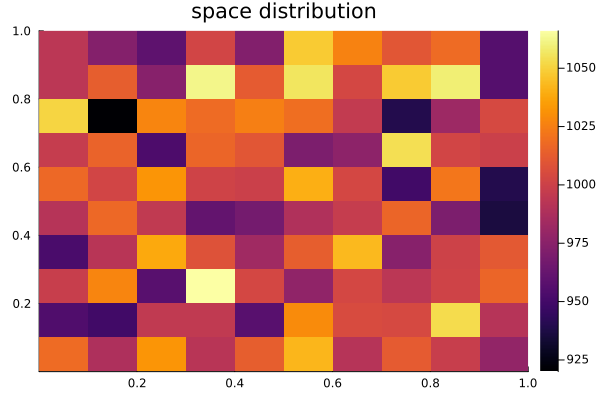

In [51]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution" ))

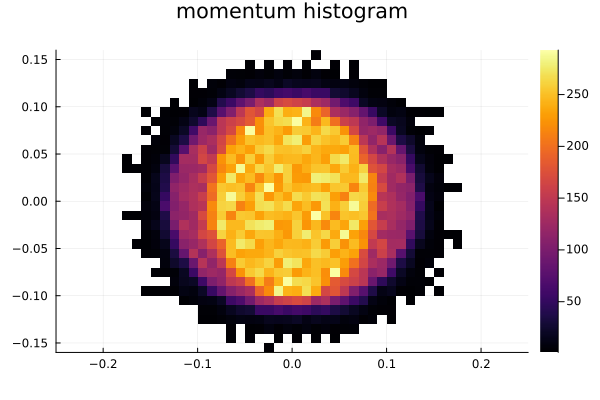

In [52]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [88]:
T = get_temperature_rel_D(par_dis,N,D)

0.0035020100176247023

In [89]:
par_grid = (N, Box_x, J, 5)
n = zeros(J)

get_density_2D!(par_dis, n, par_grid, 0.0)


50×50 Matrix{Float64}:
 0.000335301  0.000358175  0.000386202  …  0.000366579  0.000354873
 0.000384097  0.000384217  0.000381024     0.0004204    0.000409235
 0.000409829  0.000416092  0.000382088     0.00042615   0.000391672
 0.000397132  0.000435761  0.000418768     0.000415608  0.000385295
 0.000407162  0.000424441  0.000435511     0.000358929  0.000391071
 0.000373469  0.000404767  0.000423337  …  0.000340679  0.000358906
 0.000372285  0.000411113  0.000418094     0.000385558  0.000370994
 0.000388857  0.00040897   0.00041797      0.000396059  0.000389903
 0.000419735  0.000412229  0.000405541     0.000394043  0.000403136
 0.000404387  0.000380823  0.000367119     0.000356354  0.000373729
 ⋮                                      ⋱               
 0.000415364  0.000349658  0.000340112     0.000430335  0.000434051
 0.000425131  0.000379966  0.000344605     0.000416392  0.000420829
 0.000413053  0.000426343  0.00040549      0.000428292  0.000410849
 0.000407213  0.000407952  0.0004042

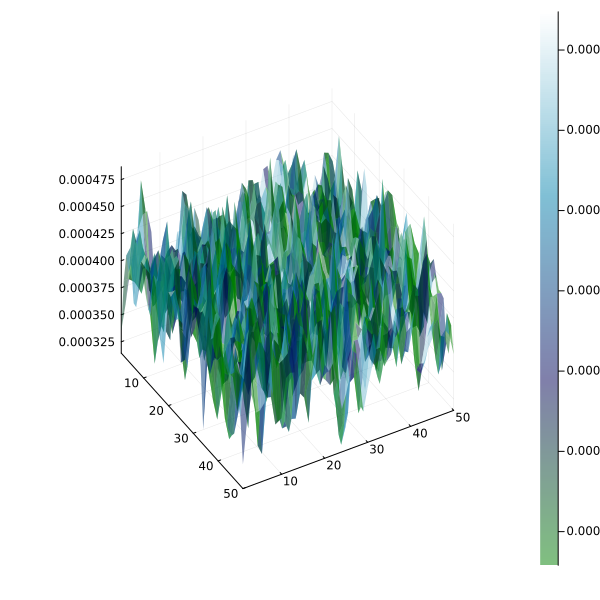

In [55]:
plot_matrix(n)

In [ ]:
#plot(n[:,5])

### Check Normalization

In [8]:
sum(n)

1.0

### Check Current

In [90]:
par_grid = (N, J, Box_x, 5)
S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
TS = zeros(Float64,(2,J...,nthreads()))

par_current_threads_S = (par_grid, TS)

get_current_threads_2D!(par_dis, S, par_current_threads_S)

@show sum(S[1,:,:])
@show sum(S[2,:,:])

sum(S[1, :, :]) = 1.3552527156068805e-19
sum(S[2, :, :]) = -8.131516293641283e-20


-8.131516293641283e-20

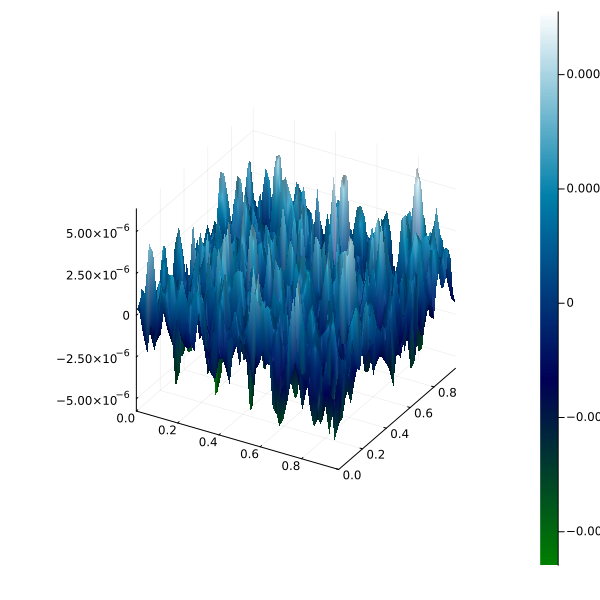

In [58]:
surface(y_p,x_p, S[1,:,:])

## Electric and Magnetic initial data

In [91]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 0.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "_B0_$(convert(Int,B0))"

"weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_1_N5_M101_o5_B0_0"

In [92]:
E = Array{Float64,3}(undef,(2,J...))
ρ = n.-1.0/prod(J)
@show sum(ρ)
get_E!(E,ρ,Box_x);

sum(ρ) = 7.697835424647081e-18


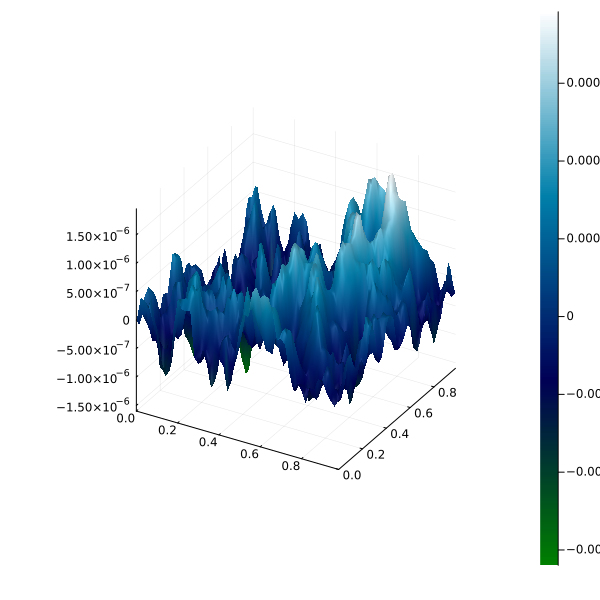

In [61]:
surface(y_p,x_p, E[2,:,:])

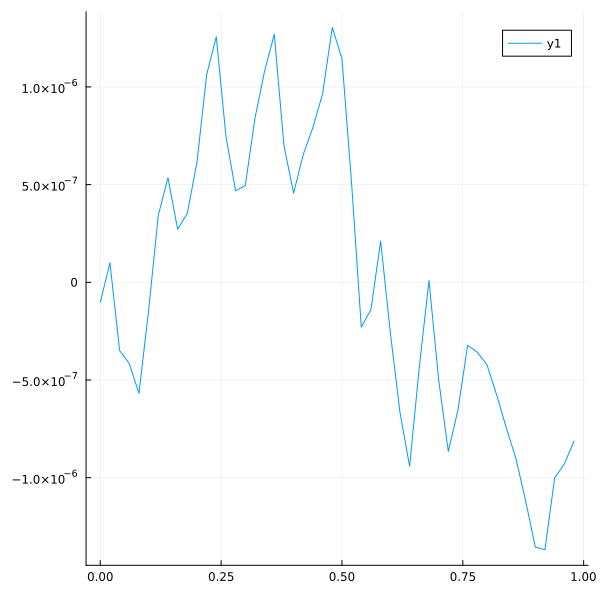

In [62]:
plot(x_p, E[1,:,50])

In [93]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
full_outputs = true
animation = true

true

We build the initial data:

In [57]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

# the total electric energy is:

(norm(E)^2 + norm(B)^2)*prod(dx)
#u
#F[3,:,:]



6.628947589345344e-13

In [ ]:
#surface(y_p,x_p,F[1,:,:])

In [58]:
Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

(0.0034931684657998415, 3.3144737946726717e-13)

In [ ]:
#surface(y_p,x_p,F[3,:,:])

In [ ]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [59]:

Coordinate_test(u,Box_x,N)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

test passed


## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [96]:
if nthreads() > 1
TS = zeros(Float64, (2,J...,nthreads()))
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Δx, σx, Dy, Δy, σy) ;
else
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Δx, σx, Dy, Δy, σy) ;
end


(100000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5, [0.00033530092510350597 0.0003581753640751105 … 0.0003665794375542356 0.00035487315996580803; 0.000384097098544604 0.00038421653853617404 … 0.0004203998789636179 0.00040923483704418285; … ; 0.00037777741004912604 0.0004232962879319326 … 0.0004033517842278926 0.0003905142459955247; 0.000336956048367199 0.0003772054621454001 … 0.00038568349763915205 0.0003665657660541334], [2.996343124300272e-7 1.346877974274495e-7 … 5.961786257482166e-7 1.050281534724536e-7; -3.5776010967975645e-8 1.311288068412368e-6 … 1.3309037041896847e-6 7.697754169403054e-7;;; 1.0858106455249002e-6 -1.2413574208299815e-6 … 1.0666859430328783e-6 3.6224211498237334e-7; -2.350871068851871e-7 -1.0608755816238105e-6 … 1.6148588660892504e-6 1.8500417255468094e-6;;; 1.4851324308295532e-6 -2.285131437245247e-6 … -1.3629477651172366e-6 1.0264660919249822e-6; 8.095106278581416e-7 -1.012855185062533e-6 … 2.9213242521724616e-6 2.003334584733615e-6;;; … ;;; -1.305192677868325e-6 -1.98

In [97]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end

if animation
    par = Array{Float64,2}(undef,M_g,length(u));
    par[1,:] = u[:]
end

407500-element Vector{Float64}:
  0.6392390206756526
  0.584671248859926
 -0.03037932338558005
  0.09215540518790018
  0.5493730078624047
  0.03657544991592269
  0.016773494992528348
 -0.08104375220984195
  0.2320717077963244
  0.07222624300038764
  ⋮
 -6.244858214634778e-7
  2.1592207203149673e-6
  0.0
 -6.298381376903376e-7
  2.216083374067309e-6
  0.0
 -1.7187736911046648e-6
  1.90540307113232e-6
  0.0

In [ ]:
#RHS_D(u,t,p_RHS_D)

In [98]:
include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D,u,t,dt,p_RHS_D)
  #global u = [make_periodic!(u[1:4N],Box_x); u[4N+1:end]]
  # make_periodic!(u,Box_x,N) # done inside the RHS_D function at every RK step
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    make_periodic!(u,Box_x,N) # just to save the correct data
    Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Total_Energy = $(Energy_Ks + Energy_Es), E_Energy = $(Energy_Es)")

    if animation
      par[j,:] = u[:]
    end
  end
end

j = 2 , t = 0.01, k = 2, nthreads = 2, Total_Energy = 0.0034931668404225096, E_Energy = 1.0088835127833084e-12


j = 3 , t = 0.02, k = 3, nthreads = 2, Total_Energy = 0.0034931668172130744, E_Energy = 9.991863889899446e-13


j = 4 , t = 0.03, k = 4, nthreads = 2, Total_Energy = 0.0034931667962632635, E_Energy = 9.904806185245161e-13


j = 5 , t = 0.04, k = 5, nthreads = 2, Total_Energy = 0.0034931667775549053, E_Energy = 9.827576602157161e-13


j = 6 , t = 0.05, k = 6, nthreads = 2, Total_Energy = 0.0034931667610641395, E_Energy = 9.760061075424933e-13


j = 7 , t = 0.060000000000000005, k = 7, nthreads = 2, Total_Energy = 0.0034931667467608296, E_Energy = 9.702117814667142e-13


j = 8 , t = 0.07, k = 8, nthreads = 2, Total_Energy = 0.0034931667346094586, E_Energy = 9.653578519556543e-13


j = 9 , t = 0.08, k = 9, nthreads = 2, Total_Energy = 0.0034931667245693267, E_Energy = 9.61424986910353e-13


j = 10 , t = 0.09, k = 10, nthreads = 2, Total_Energy = 0.0034931667165944724, E_Energy = 9.583915228505477e-13


j = 11 , t = 0.09999999999999999, k = 11, nthreads = 2, Total_Energy = 0.0034931667106345063, E_Energy = 9.562336549836135e-13


In [19]:
j = 11

Plots.scatter(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

png("weibel_space_t=10")

"weibel_space_t=10.png"

In [63]:
include("aux_functions/aux_functions.jl")
par_v = par[11,:]
#make_periodic!(par_v,Box_x,N)
Coordinate_test(par_v,Box_x,N)

test passed


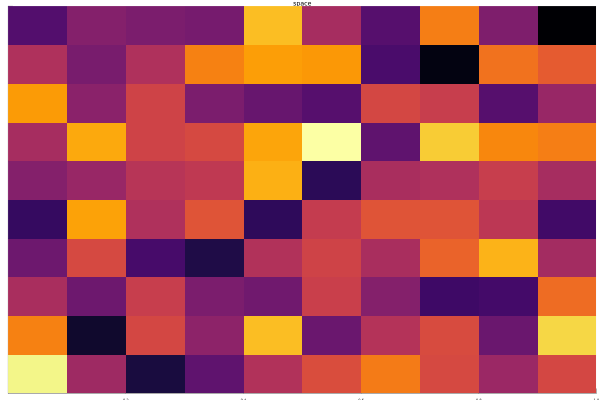

In [29]:
j = 11

histogram2d(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

In [31]:
j = 11
Plots.scatter(par[j,3:2D:4N], par[j,4:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "momentum", legend =:false)

png("weibel_momentum_t=10")

"weibel_momentum_t=10.png"

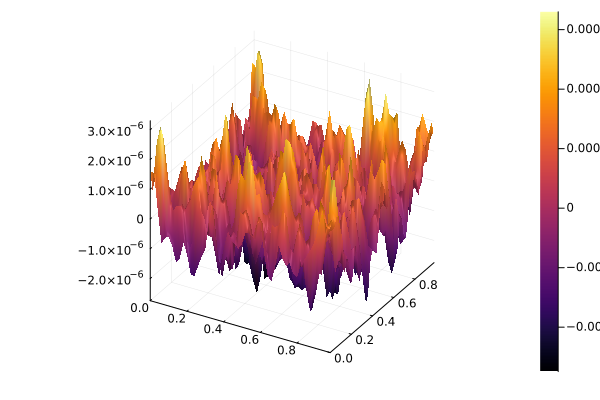

In [99]:
j = 11
Fuj = view(par[j,:],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

surface(y_p,x_p,Ej[2,:,:])
#surface(y_p,x_p,Bj[:,:])

#norm(Bj)

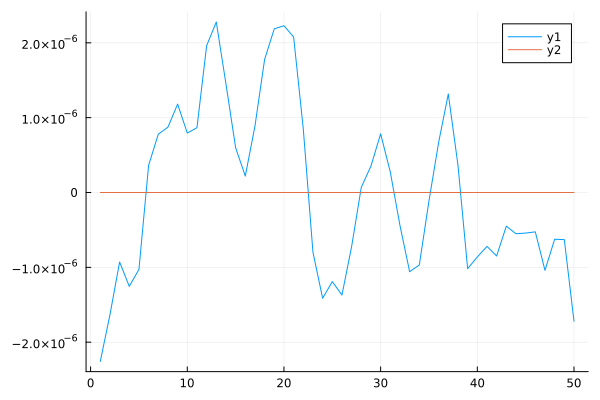

In [71]:
plot(Ej[1,:,50])
plot!(Bj[:,50])

### Constraint cheking

In [100]:
#j = 11
par_grid = (N, Box_x, J, 5)
nf = zeros(J)
get_density_2D!(par[j,1:4N], nf, par_grid, 0.0)

Ef = Array{Float64,3}(undef,(2,J...))
ρf = nf.-1.0/prod(J)
@show sum(ρf)
get_E!(Ef,ρf,Box_x);

sum(ρf) = -1.6263032587282567e-19


In [101]:
norm(Ef - Ej)/norm(Ej)

0.8838970887039989

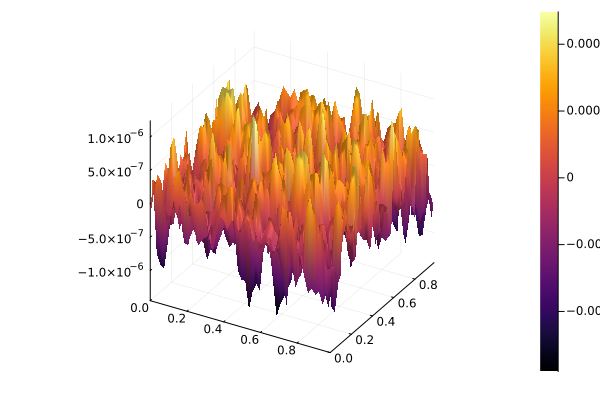

In [69]:
l=2
surface(y_p,x_p,Ef[l,:,:] - Ej[l,:,:])
#surface(y_p,x_p,Ef[l,:,:])

### The constraints are not working well....

#### It seems to be lot of highg frequency noice.

Saving the results

In [ ]:
if remote_server
    exit() #if running as script
end

In [ ]:
rfft(E_i)[nm+1]

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |


In [37]:
#Plots.scatter(eigvals(Matrix(Δx))*dx[1])
eigvals(Matrix(Δx))*dx[1]

50-element Vector{Float64}:
 -1.28
 -1.2649198388950886
 -1.2649198388950877
 -1.2206222449845632
 -1.220622244984563
 -1.1498495337766927
 -1.1498495337766919
 -1.0568940596024496
 -1.0568940596024492
 -0.9472135954999579
  ⋮
 -0.000302801987468496
 -0.00030280198746844827
 -5.5407385585086334e-5
 -5.540738558495771e-5
 -4.961436492216854e-6
 -4.961436492080907e-6
 -7.844665488039279e-8
 -7.844665473420914e-8
  6.406965268943513e-17

In [38]:
maximum(abs.(eigvals(Matrix(Dx + Δx))*dx[1]))

1.6474500769430924

In [78]:
eigvals(Matrix(Dx))*dx[1]

50-element Vector{ComplexF64}:
 -1.3200619093930392e-16 + 0.0im
  -5.329070518200751e-17 - 0.2513269653810572im
  -5.329070518200751e-17 + 0.2513269653810572im
  -5.301314942585123e-17 - 0.12566370261982263im
  -5.301314942585123e-17 + 0.12566370261982263im
  -3.552713678800501e-17 - 1.2306563570119078im
  -3.552713678800501e-17 + 1.2306563570119078im
 -2.6645352591003756e-17 - 0.3769835989972778im
 -2.6645352591003756e-17 + 0.3769835989972778im
 -1.5543122344752193e-17 - 0.5025996911162439im
                         ⋮
    4.08006961549745e-17 + 0.27487763491873546im
   4.884981308350689e-17 - 1.1986967172037633im
   4.884981308350689e-17 + 1.1986967172037633im
   7.105427357601002e-17 - 0.9992215469653606im
   7.105427357601002e-17 + 0.9992215469653606im
   7.993605777301127e-17 - 0.8771421447484702im
   7.993605777301127e-17 + 0.8771421447484702im
   8.215650382226158e-17 - 0.5403791698420866im
   8.215650382226158e-17 + 0.5403791698420866im